In [1]:
## Import data
%matplotlib notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import sklearn

PRESSURE_PATH = '/home/ubuntu/CAAM/496_New_Data/pressure/'   # pressure data
SATURATION_PATH = '/home/ubuntu/CAAM/496_New_Data/saturation/' # saturation data
PRODUCTION_PATH = '/home/ubuntu/CAAM/496_New_Data/production/' # production data
ROCK_PATH = '/home/ubuntu/CAAM/496_New_Data/rock/'

def pullseries(PATH, NAME, index_list):
    # input: NAME - 'saturation' or 'pressure'
    data = []
    for i in index_list:
        temp_data = np.loadtxt(PATH+NAME+str(i)+'.txt',delimiter = ',')
        #temp_data = np.reshape(temp_data,(75,60,220),order ='F')
        data.append(temp_data)
    data = np.float32(data)
    # restructure data into long array (total snapshots , 13200)
    # total snapshots = n X 75
    # 13200 = total grid points = 60 X 220
    data = data.reshape((data.shape[0]*data.shape[1],data.shape[2])) 
    return data

def pullporosity(ROCK_PATH, index_list):
    data = []
    for i in index_list:
        temp_data = np.loadtxt(ROCK_PATH + '/rock'+str(i)+'.txt', delimiter=',')
        data.append(temp_data[[0]])
    data = np.float32(data)
    data = data.reshape((data.shape[0]*data.shape[1],data.shape[2])) 
    return data

def pull

# function to compare resulting sequential states
def animate_compare(y1,y2):
    fig = plt.figure()
    ax1 = fig.add_subplot(211)
    ax2 = fig.add_subplot(212)
    plt.ion()
    fig.show()
    fig.canvas.draw()
    for i in range(len(y1)):    
        ax1.clear()
        ax1.imshow(np.reshape(y1[i,:],(60,220),order ='F'))
        ax2.clear()
        ax2.imshow(np.reshape(y2[i,:],(60,220),order ='F'))
        fig.canvas.draw()
        plt.pause(0.05)
# plt.title('Water Saturation')
# plt.savefig('Saturation Plot X_1.png')

def animate_single(X):
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    plt.ion()
    fig.show()
    fig.canvas.draw()
    for i in range(len(X)):    
        ax1.clear()
        ax1.imshow(np.reshape(X[i,:],(60,220),order ='F'))
        fig.canvas.draw()
        plt.pause(0.05)
        
def animate_encoded(X,decoder,index_range):
    # sanity check on stacked encoded space
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    plt.ion()
    fig.show()
    fig.canvas.draw()
#     print(X.shape)
    decoded_X = decoder.predict(X[:,:,:,index_range])
#     print(decoded_X)
    for i in range(len(decoded_X)):
        ax1.clear()
        ax1.imshow(np.reshape(decoded_X[i],(60,220),order = 'F'))
        fig.canvas.draw()
        plt.pause(0.01)

<IPython.core.display.Javascript object>


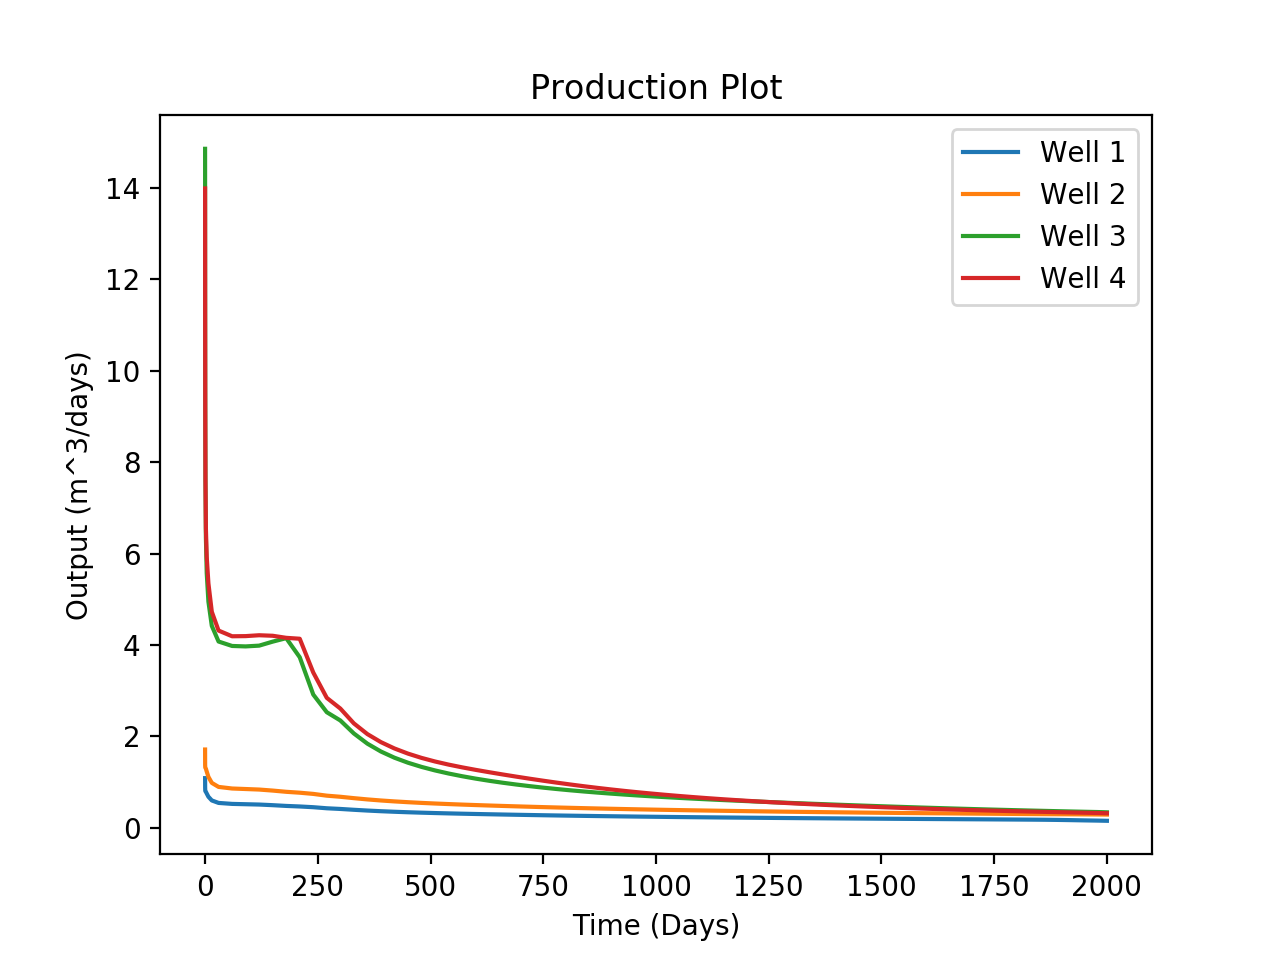

In [2]:
# check production data
Prod_unsized = np.loadtxt(PRODUCTION_PATH + 'production2.txt')
Prod_resized = np.array([Prod_unsized[:,0]/3600.0/24.0, 
                         Prod_unsized[:,1]*3600*24,
                         Prod_unsized[:,2]*3600*24,
                         Prod_unsized[:,3]*3600*24,
                         Prod_unsized[:,4]*3600*24])
well_1 = plt.plot(Prod_resized[0,],Prod_resized[1,],label='Well 1')
well_2 = plt.plot(Prod_resized[0,],Prod_resized[2,],label='Well 2')
well_3 = plt.plot(Prod_resized[0,],Prod_resized[3,],label='Well 3')
well_4 = plt.plot(Prod_resized[0,],Prod_resized[4,],label='Well 4')
plt.title('Production Plot')
# plt.yscale('log')
plt.xlabel('Time (Days)')
plt.ylabel('Output (m^3/days)')
plt.legend()
plt.savefig('Production Plot2.png')

In [2]:
# Specify files to read for testing and training
train_files = np.arange(1,81)
test_files = np.arange(81,101)

In [3]:
# pull porosity from Rock files
RTRAIN = pullporosity(ROCK_PATH, train_files)
RTEST = pullporosity(ROCK_PATH, test_files)
# reshape porosity data to feed into autoencoder (channel last)
Rtrain = RTRAIN
Rtest = RTEST
Rtrain_reshaped = np.reshape(Rtrain,(len(Rtrain), 60, 220, 1),order= 'F')
Rtest_reshaped = np.reshape(Rtest,(len(Rtest), 60, 220, 1),order= 'F')

In [4]:
# pull saturation data
STRAIN = pullseries(SATURATION_PATH, 'saturaton', train_files)
STEST = pullseries(SATURATION_PATH, 'saturaton', test_files)

Strain = STRAIN
Stest = STEST
Strain_reshaped = np.reshape(Strain,(len(Strain), 60, 220, 1),order= 'F')
Stest_reshaped = np.reshape(Stest,(len(Stest), 60, 220, 1),order= 'F')

(6000, 60, 220, 1)


<IPython.core.display.Javascript object>


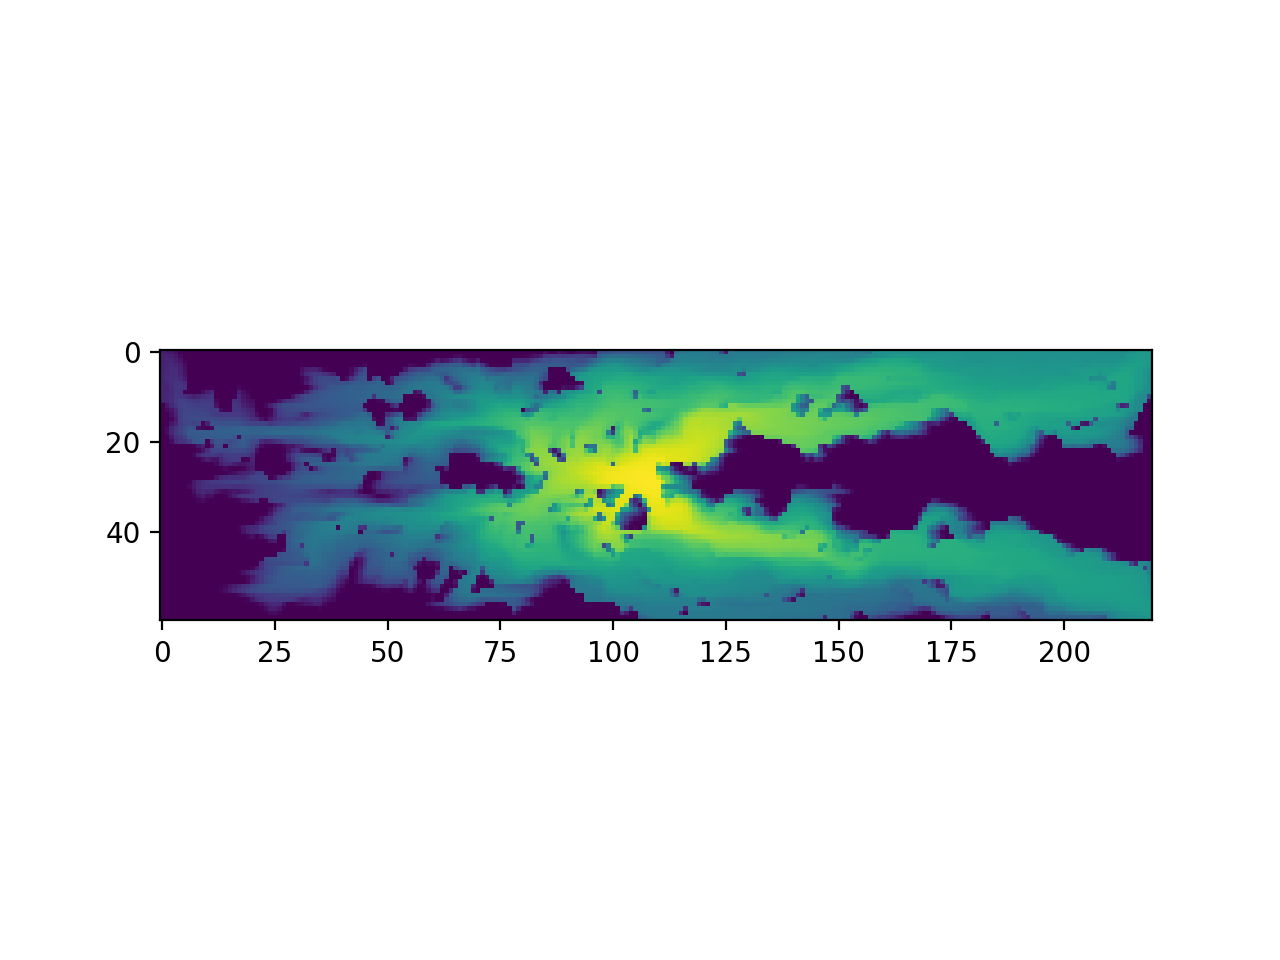

In [6]:
# sanity check for first pass of data
# here pressure data is checked
print(Strain_reshaped.shape)
interval = np.arange(75,150)
animate_single(Strain_reshaped[interval,])

In [6]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Reshape
from keras.models import Model
from keras import backend as K
from keras.models import load_model
from keras.callbacks import TensorBoard
# the constructer will instantiate the model as specified 
# (one model for each type of data)
def construct_autoencoder_model(channels_numbers):
    # tuple channel_numebers contain the channel numbers for 3 convolutional layers
    # default should be 16,12,8 
    input_img = Input(shape=(60, 220, 1))  # y, x
    x = Conv2D(channels_numbers[0], (6, 11), activation='relu', padding="same")(input_img)
    x = MaxPooling2D((1, 2), padding='same')(x)
    x = Conv2D(channels_numbers[1], (5, 5), activation='relu', padding='same')(x)
    x = MaxPooling2D((5, 5), padding='same')(x)
    x = Conv2D(channels_numbers[2], (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)
    # encoded space (6, 11, ?)
    x = Conv2D(channels_numbers[2], (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(channels_numbers[1], (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((5, 5))(x)
    x = Conv2D(channels_numbers[0], (5, 5), activation='relu', padding='same')(x)
    x = UpSampling2D((1, 2))(x)
    decoded = Conv2D(1, (6, 11), activation='sigmoid', padding='same')(x)
    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='mean_absolute_percentage_error')
    encoded_shape = autoencoder.layers[7].output.shape[1:]
    encoded_shape = tuple([int(encoded_shape[i]) for i in range(len(encoded_shape)) ])
#     autoencoder.summary()
    return autoencoder, encoded_shape

In [19]:
from keras.models import Model, Sequential
# input_dim = Input(shape=(60,220,1))

# x = Reshape((13200), input_shape=input_dim)
# x = Dense(4*encoding_dim, activation='relu')(x)
# x = Dense(2*encoding_dim, activation='relu')(x)
# encoded = Dense(encoding_dim, activation='relu')(x)

# x = Dense(encoding_dim, activation='relu')(encoded)
# x = Dense(2*encoding_dim, activation='relu')(x)
# x = Dense(4*encoding_dim, activation='relu')(x)
# x = Dense((13200), activation='sigmoid')(x)
# decoded = Reshape((60,220,1))(x)
# autoencoder = Model(input_img, decoded)
# autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
# autoencoder.summary()


autoencoder = Sequential()
encoding_dim = 60*22
# Encoder Layers
autoencoder.add(Reshape((1,13200), input_shape=(60,220,1)))
autoencoder.add(Dense(4 * encoding_dim, input_shape=(input_dim,), activation='relu'))
autoencoder.add(Dense(2 * encoding_dim, activation='relu'))
autoencoder.add(Dense(encoding_dim, activation='relu'))

# Decoder Layers
autoencoder.add(Dense(2 * encoding_dim, activation='relu'))
autoencoder.add(Dense(4 * encoding_dim, activation='relu'))
autoencoder.add(Dense(13200, activation='sigmoid'))
autoencoder.add(Reshape((60,220,1), input_shape=(1,13200)))
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_14 (Reshape)         (None, 1, 13200)          0         
_________________________________________________________________
dense_32 (Dense)             (None, 1, 5280)           69701280  
_________________________________________________________________
dense_33 (Dense)             (None, 1, 2640)           13941840  
_________________________________________________________________
dense_34 (Dense)             (None, 1, 1320)           3486120   
_________________________________________________________________
dense_35 (Dense)             (None, 1, 2640)           3487440   
_________________________________________________________________
dense_36 (Dense)             (None, 1, 5280)           13944480  
_________________________________________________________________
dense_37 (Dense)             (None, 1, 13200)          69709200  
__________

In [20]:
def train_autoencoder(model, iterations, TRAIN, TEST, name):
    # names: R for porosity, P for pressure, S for saturation
    model.fit(TRAIN, TRAIN,
                epochs = iterations,
                batch_size = 10,
                shuffle=True,
                validation_data=(TEST, TEST),
                verbose = 1)
    model.save(name+'autoencoder.h5')
    return model

In [9]:
# retreiving encoder and decoder from autoencoder
def retrieve_coders(name,encoded_shape):
    # check what encoded shape is first
    # default (8,28,8)
    autoencoder = load_model(name+'autoencoder.h5')
    encoded_input = Input(shape=encoded_shape)
    deco = autoencoder.layers[-7](encoded_input)
    deco = autoencoder.layers[-6](deco)
    deco = autoencoder.layers[-5](deco)
    deco = autoencoder.layers[-4](deco)
    deco = autoencoder.layers[-3](deco)
    deco = autoencoder.layers[-2](deco)
    deco = autoencoder.layers[-1](deco)
    # create the decoder model
    decoder = Model(encoded_input, deco)
    # decoder.summary()
#     decoder.summary()

    input_img = Input(shape=(60, 220, 1))
    enco = autoencoder.layers[1](input_img)
    enco = autoencoder.layers[2](enco)
    enco = autoencoder.layers[3](enco)
    enco = autoencoder.layers[4](enco)
    enco = autoencoder.layers[5](enco)
    enco = autoencoder.layers[6](enco)
    encoder = Model(input_img, enco)
#     encoder.summary()
    return decoder, encoder, autoencoder


In [ ]:
autoencoder = train_autoencoder(autoencoder, 5, Strain_reshaped, Stest_reshaped, 'S_Dense')

Instructions for updating:
Use tf.cast instead.
Train on 6000 samples, validate on 1500 samples
Epoch 1/5
6000/6000 [==============================] - 150s 25ms/step - loss: 0.6024 - val_loss: 0.5867
Epoch 2/5
6000/6000 [==============================] - 132s 22ms/step - loss: 0.5821 - val_loss: 0.5846
Epoch 3/5
6000/6000 [==============================] - 153s 26ms/step - loss: 0.5781 - val_loss: 0.5835
Epoch 4/5
6000/6000 [==============================] - 150s 25ms/step - loss: 0.5758 - val_loss: 0.5841
Epoch 5/5
5420/6000 [==========================>...] - ETA: 14s - loss: 0.5737

In [10]:
####### EXAMPLE AUTOENCODER FOR ROCK #########
# construct autoencoder model
Rautoencoder, Rencoded_shape = construct_autoencoder_model((12,12,8))
# train autoencoder
Rautoencoder = train_autoencoder(Rautoencoder, 30, Rtrain_reshaped, Rtest_reshaped, 'R')
# retrieve encoder and decoder
Rdecoder, Rencoder, Rautoencoder = retrieve_coders('R', Rencoded_shape)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 80 samples, validate on 20 samples
Epoch 1/30
80/80 [==============================] - 3s 38ms/step - loss: 420.7598 - val_loss: 317.6510
Epoch 2/30
80/80 [==============================] - 0s 5ms/step - loss: 141.3540 - val_loss: 98.3436
Epoch 3/30
80/80 [==============================] - 0s 5ms/step - loss: 99.3609 - val_loss: 99.8703
Epoch 4/30
80/80 [==============================] - 0s 5ms/step - loss: 99.9451 - val_loss: 99.9589
Epoch 5/30
80/80 [==============================] - 0s 5ms/step - loss: 99.9812 - val_loss: 99.9784
Epoch 6/30
80/80 [==============================] - 0s 5ms/step - loss: 99.9871 - val_loss: 99.9836
Epoch 7/30
80/80 [==============================] - 0s 5ms/step - loss: 99.9894 - val_loss: 99.9853
Epoch 8/30
80/80 [==============================] - 0s 5ms/step - loss: 99.9902 - val_loss: 99.9860
Epoch 9/30
80/80 [==============

In [11]:
# # construct autoencoder model
Sautoencoder, Sencoded_shape = construct_autoencoder_model((16,12,8))
# # train autoencoder
Sautoencoder = train_autoencoder(Sautoencoder, 5, Strain_reshaped, Stest_reshaped, 'S')
# # retrieve encoder and decoder
Sdecoder, Sencoder, Sautoencoder = retrieve_coders('S', Sencoded_shape)

Train on 6000 samples, validate on 1500 samples
Epoch 1/10
6000/6000 [==============================] - 36s 6ms/step - loss: 17.0297 - val_loss: 11.8916
Epoch 2/10
6000/6000 [==============================] - 35s 6ms/step - loss: 10.0684 - val_loss: 11.1614
Epoch 3/10
6000/6000 [==============================] - 35s 6ms/step - loss: 8.9067 - val_loss: 9.7758
Epoch 4/10
6000/6000 [==============================] - 34s 6ms/step - loss: 8.4167 - val_loss: 9.7283
Epoch 5/10
6000/6000 [==============================] - 34s 6ms/step - loss: 8.2027 - val_loss: 9.0863
Epoch 6/10
1360/6000 [=====>........................] - ETA: 24s - loss: 8.1285

KeyboardInterrupt: 

In [15]:
# # construct autoencoder model
Sautoencoder, Sencoded_shape = construct_autoencoder_model((16,12,4))
# # train autoencoder
Sautoencoder = train_autoencoder(Sautoencoder, 5, Strain_reshaped, Stest_reshaped, 'S')
# # retrieve encoder and decoder
Sdecoder, Sencoder, Sautoencoder = retrieve_coders('S', Sencoded_shape)

Train on 6000 samples, validate on 1500 samples
Epoch 1/5
6000/6000 [==============================] - 36s 6ms/step - loss: 18.1122 - val_loss: 12.3997
Epoch 2/5
6000/6000 [==============================] - 35s 6ms/step - loss: 10.5927 - val_loss: 10.9310
Epoch 3/5
6000/6000 [==============================] - 35s 6ms/step - loss: 9.8214 - val_loss: 10.1680
Epoch 4/5
1530/6000 [======>.......................] - ETA: 23s - loss: 9.5914

KeyboardInterrupt: 